# LSTM-RNN Model Selection for Chile Inflation Forecasting

This notebook is intended to find the most accurate LSTM-RNN model for an 11-months forecast horizon by tunning the hyper-parameters of the Neural Network.

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot(x_data, y_data, x_label='Date', y_label='Value', format='-', title=None):
    plt.plot(x_data, y_data, format)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True, color='0.80')

In [3]:
def create_window(series, window_size, forecast_horizon=0):
    output_data = series[window_size+forecast_horizon:]
    input_list = []
    for i in range(series.shape[0] - window_size - forecast_horizon):
        input_list.append(series[i:i + window_size])
    input_data = np.array(input_list)
    input_data = input_data.reshape(input_data.shape[0], input_data.shape[1], 1)
    output_data = output_data.reshape(output_data.shape[0], 1)
    return input_data, output_data

In [4]:
def neural_network_model(
    train_data, n_lags, hidden_units, epochs, learning_rate, forecast_horizon=0):
    input_data, output_data = create_window(train_data, n_lags, forecast_horizon)

    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(hidden_units, input_shape=(n_lags, 1)),
        tf.keras.layers.Dense(1)
    ])

    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=2)
    model.fit(input_data, output_data, epochs=epochs, verbose=0, shuffle=False, callbacks=[callback])
    return model

In [5]:
def calculate_mse(series_test, n_lags, model, forecast_horizon=0):
    forecasts = []
    input_data, output_data = create_window(series_test, n_lags)
    for data in input_data:
        data = data.reshape(1, data.shape[0], data.shape[1])
        prediction = model.predict(data)
        forecasts.append(prediction[0][0])
    squared_forecast_error = []
    for i in range(len(forecasts)):
        squared_forecast_error.append((output_data[i][0] - forecasts[i]) ** 2)
    return (sum(squared_forecast_error)) / len(squared_forecast_error)

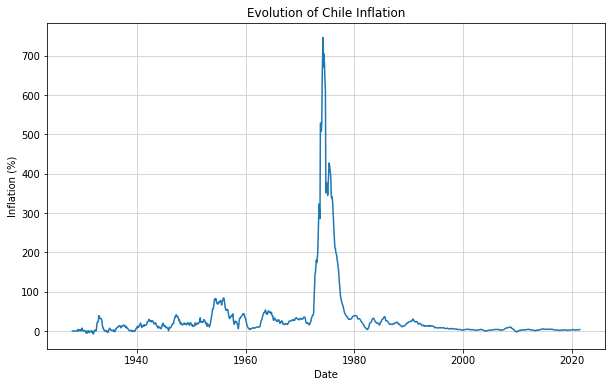

In [6]:
import csv
import datetime

period = []
inflation = []
with open('data/chile_inflation.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    next(reader)
    for row in reader:
        if row[1] != '':
            inflation.append(float(row[1]))
            year = int(row[0][:4])
            month = int(row[0][5:])
            period.append(datetime.date(year, month, 1))

series = np.array(inflation)
time = np.array(period)
plt.figure(figsize=(10, 6))
plot(time, series, y_label='Inflation (%)', title='Evolution of Chile Inflation')

---

# Forecast Horizon: 11 months ahead

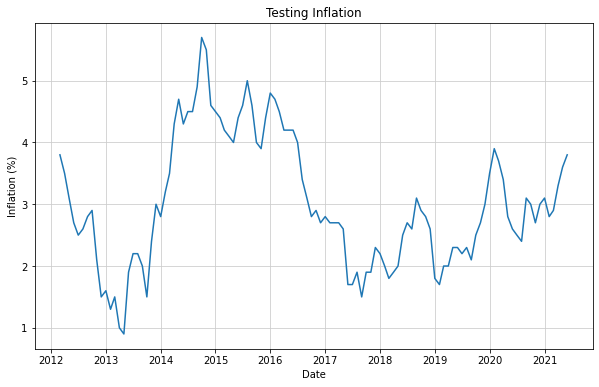

In [7]:
split_time = round(0.9 * series.shape[0])

inflation_train = series[:split_time]
time_train = time[:split_time]
inflation_test = series[split_time:]
time_test = time[split_time:]

plt.figure(figsize=(10, 6))
plot(time_test, inflation_test, y_label='Inflation (%)', title='Testing Inflation')

## Hyper-parameter Optimization

Since the best RNN model for Chile inflation is not known *a priori*, I have to code a program which will let me know what is the best Neural Networks hyper-parameters that will make the best predictions.

The code below is intended to test 960 models. All of them are unique, and each one predicts using unique weights, but I will use only the top 10 models to predict inflation.

The way I choose the best NN models is watching the Mean Squared Error (MSE) of their predictions.

In [8]:
from IPython.display import clear_output

# Hyper-parameters
n_lags = range(12, 24+1, 4)
hidden_units = range(50, 100+1, 10)
epochs = range(200, 500+1, 100)
learning_rates = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]
horizon = 11

hyper_parameters = []
mse = []

with open('hyper_parameter_optimization_11_months.csv', 'w') as file:
    file.write('n_lags,hidden_units,epochs,learning_rate,mse')

for lag in n_lags:
    for unit in hidden_units:
        for epoch in epochs:
            for learning_rate in learning_rates:
                print(f'Training the model using: {lag} lags,',
                      f'{unit} hidden units, {epoch} epochs,',
                      f'{learning_rate} learning rate')
                clear_output(wait=True)
                hyper_parameters.append([lag, unit, epoch, learning_rate])
                model = neural_network_model(
                    inflation_train, lag, unit, epoch, learning_rate, forecast_horizon=horizon)
                model_mse = calculate_mse(inflation_test, lag, model, forecast_horizon=horizon)
                mse.append(model_mse)
                with open('hyper_parameter_optimization_11_months.csv', 'a') as file:
                    file.write(f'\n{lag},{unit},{epoch},{learning_rate},{model_mse}')

Training the model using: 24 lags, 100 hidden units, 500 epochs, 0.01 learning rate


In [9]:
print('Top 10 hyperparameters:\n')
print(['lags', 'neuron units', 'epochs', 'learning rate'])
sorted_mse = sorted(mse)
for i in range(10):
    print(hyper_parameters[mse.index(float(sorted_mse[i]))], f'MSE: {round(sorted_mse[i], 4)}')

Top 10 hyperparameters:

['lags', 'neuron units', 'epochs', 'learning rate']
[12, 80, 200, 0.008] MSE: 0.1915
[20, 100, 500, 0.01] MSE: 0.2203
[24, 80, 300, 0.001] MSE: 0.222
[12, 90, 200, 0.009] MSE: 0.238
[12, 80, 500, 0.01] MSE: 0.265
[20, 80, 400, 0.003] MSE: 0.3101
[16, 80, 300, 0.002] MSE: 0.3167
[20, 80, 300, 0.005] MSE: 0.3252
[20, 70, 300, 0.003] MSE: 0.3372
[20, 50, 500, 0.008] MSE: 0.3472


---

## Top 3 model performance

Model #1
Hyperparameters: 12 lags, 80 units, 200 epochs, 0.008 learning rate 

Model #2
Hyperparameters: 20 lags, 100 units, 500 epochs, 0.01 learning rate 

Model #3
Hyperparameters: 24 lags, 80 units, 300 epochs, 0.001 learning rate 



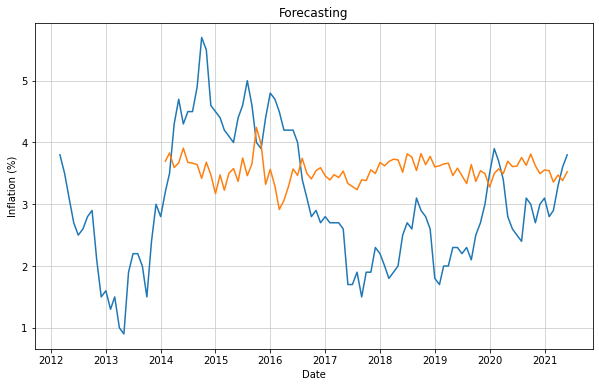

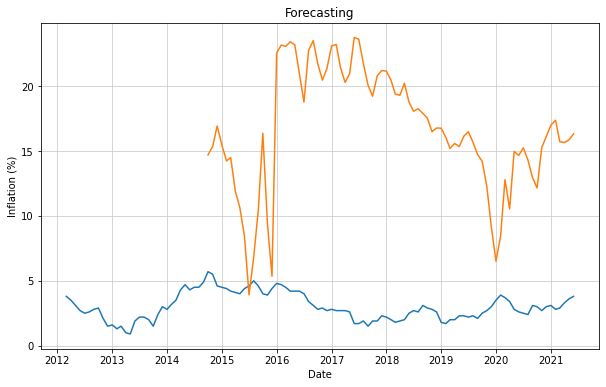

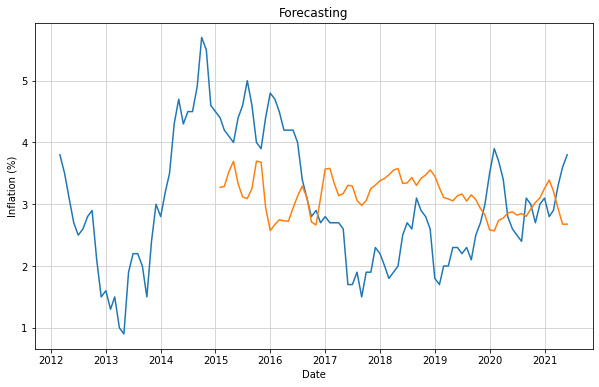

In [10]:
for i in range(3):
    lag, unit, epoch, learning_rate = hyper_parameters[mse.index(float(sorted_mse[i]))]
    model = neural_network_model(inflation_train, lag, unit, epoch, learning_rate, forecast_horizon=horizon)
    print(f'Model #{i+1}')
    print(f'Hyperparameters: {lag} lags, {unit} units, {epoch} epochs,',
          f'{learning_rate} learning rate', '\n')
    
    forecasts = []
    input_data, output_data = create_window(inflation_test, lag, forecast_horizon=horizon)
    for data in input_data:
        data = data.reshape(1, data.shape[0], data.shape[1])
        prediction = model.predict(data)
        forecasts.append(prediction[0][0])
    
    plt.figure(figsize=(10, 6))
    plot(time_test, inflation_test)
    plot(time_test[lag+horizon:], forecasts, y_label='Inflation (%)', title='Forecasting')